In [210]:
from jax import numpy as np
import numpy as onp
from jax import random, jit, lax, ops, grad
from jax_md import space, smap, energy, minimize, quantity, simulate
from jax.config import config ; config.update('jax_enable_x64', True)

In [217]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
    plt.xlabel(x, fontsize=20)
    plt.ylabel(y, fontsize=20)
    
def finalize_plot(shape=(1, 1)):
    plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
    plt.tight_layout()
    
def plot_system(R,box_size,species=None,ms=20):
    R_plt = onp.array(R)

    if(species is None):
      plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
    else:
      for ii in range(np.amax(species)+1):
        Rtemp = R_plt[species==ii]
        plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

    plt.xlim([0, box_size])
    plt.ylim([0, box_size])
    plt.xticks([], [])
    plt.yticks([], [])

    finalize_plot((1,1))

In [218]:
N = 400
dimension = 2
density = 0.84
box_size = quantity.box_size_at_number_density(N, density, dimension)
dt = 5e-3
displacement, shift = space.periodic(box_size) 

kT = 0.1

In [219]:
key = random.PRNGKey(0)
key, split = random.split(key)
R = box_size * random.uniform(split, (N, dimension), dtype=np.float64)


In [220]:
# The system ought to be a 2 particles interacting via Morse potential in a LJ fluid.


def total_energy_fn(R):
    
    epsilon = np.ones((N, N))
    particles_index = [0, 10]
    epsilon = epsilon.at[particles_index[0],particles_index[1]].set(0.)
    epsilon = epsilon.at[particles_index[1],particles_index[0]].set(0.)
    
    solvent_energy_fn = energy.lennard_jones_pair(displacement, sigma=1.0, epsilon=epsilon, r_cutoff=2.5)

    
    epsilon = np.zeros((N, N))
    particles_index = [0, 10]
    epsilon = epsilon.at[particles_index[0],particles_index[1]].set(5.)
    epsilon = epsilon.at[particles_index[1],particles_index[0]].set(5.)

    particle_energy_fn = energy.morse_pair(displacement, sigma=1.0, epsilon=epsilon, alpha=5.0, r_cutoff=2.5)
    
    return particle_energy_fn(R) + solvent_energy_fn(R)
    
    
init, apply = simulate.nvt_nose_hoover(total_energy_fn, shift, dt, kT)
state = init(key, R)

In [221]:
def run_minimization(energy_fn, R_init, shift, num_steps=5000):
    dt_start = 0.001
    dt_max   = 0.004
    init,apply=minimize.fire_descent(jit(energy_fn),shift,dt_start=dt_start,dt_max=dt_max)
    apply = jit(apply)

    @jit
    def scan_fn(state, i):
        return apply(state), 0.

    state = init(R_init)
    state, _ = lax.scan(scan_fn,state,np.arange(num_steps))

    return state.position, np.amax(np.abs(-grad(total_energy_fn)(state.position)))

largest component of force after minimization = 0.4716959164624689


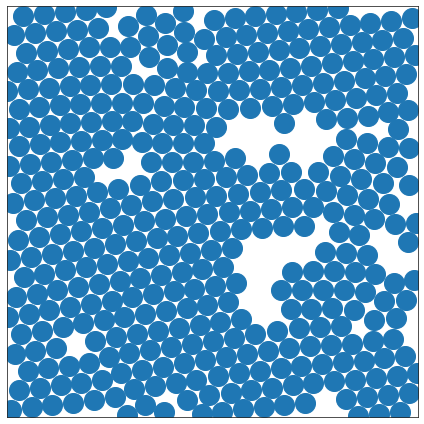

In [222]:
Rfinal, max_force_component = run_minimization(total_energy_fn, R, shift)
print('largest component of force after minimization = {}'.format(max_force_component))
plot_system( Rfinal, box_size )

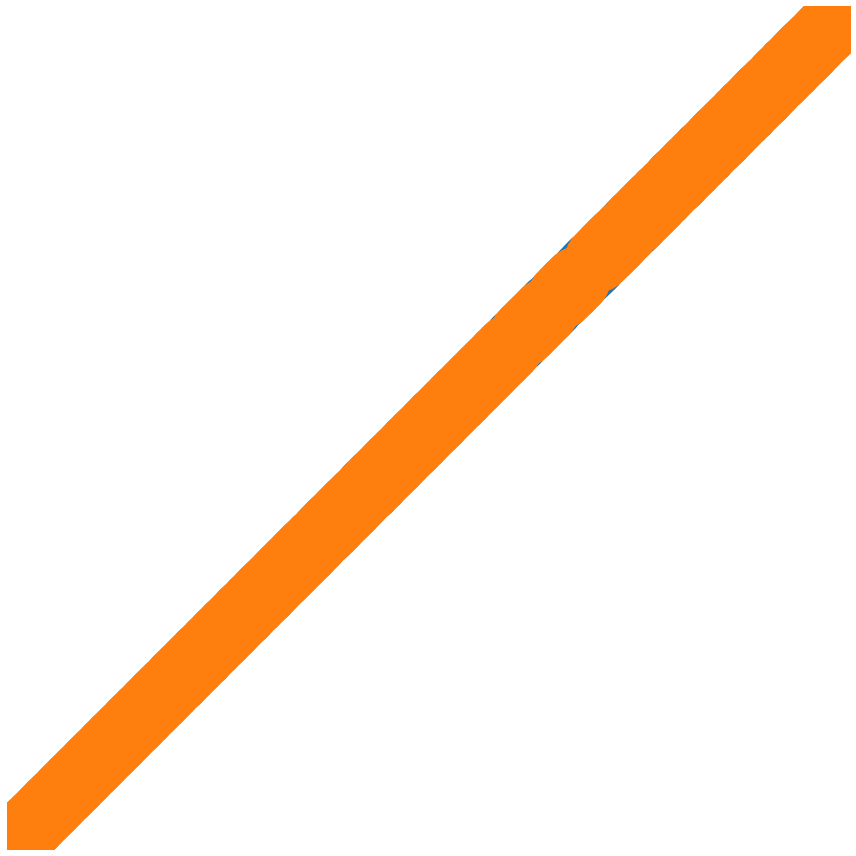

In [228]:
ms = 65
R_plt = onp.array(Rfinal)

plt.plot(R_plt, R_plt, 'o', markersize=ms * 1)
#plt.plot(R_plt[particles_index[0]], R_plt[particles_index[1]], 'o', markersize=ms * 1, color='red')

#plt.xlim([0, np.max(R[:, 0])])
#plt.ylim([0, np.max(R[:, 1])])

plt.xlim([0, box_size])
plt.ylim([0, box_size])

plt.axis('off')

finalize_plot((2, 2))

In [223]:
write_every = 100

def step_fn(i, state_and_log):
    state, log = state_and_log

    t = i * dt

    # Log information about the simulation.
    # NOTE: Warning: As of v0.2.0 the internal representation of JAX MD simulations 
    # has changed from velocity to momentum. For the most part this should not affect your work, 
    # but the inputs to quantity.kinetic_energy and quantity.temperature have changed 
    # from taking velocity to momentum!


    T = quantity.temperature(velocity=state.velocity)
    log['kT'] = log['kT'].at[i].set(T)
    H = simulate.nvt_nose_hoover_invariant(total_energy_fn, state, kT)
    log['H'] = log['H'].at[i].set(H)
    # Record positions every `write_every` steps.
    log['position'] = lax.cond(i % write_every == 0,
                                lambda p: \
                                p.at[i // write_every].set(state.position),
                                lambda p: p,
                                log['position'])

    # Take a simulation step.
    state = apply(state) # kT=kT)
    
    return state, log

In [204]:
steps = 100

log = {
    'kT': np.zeros((steps,)),
    'H': np.zeros((steps,)),
    'position': np.zeros((steps // write_every,) + R.shape) 
}

state, log = lax.fori_loop(0, steps, step_fn, (state, log))

R = state.position

In [205]:
t = onp.arange(0, steps) * dt
#plt.plot(t, log['kT'], linewidth=3)
#plt.plot(t, t, linewidth=3)
#format_plot('$t$', '$T$')
#finalize_plot()
log['H']

DeviceArray([2.9776863e+12,           nan,           nan,           nan,
                       nan,           nan,           nan,           nan,
                       nan,           nan,           nan,           nan,
                       nan,           nan,           nan,           nan,
                       nan,           nan,           nan,           nan,
                       nan,           nan,           nan,           nan,
                       nan,           nan,           nan,           nan,
                       nan,           nan,           nan,           nan,
                       nan,           nan,           nan,           nan,
                       nan,           nan,           nan,           nan,
                       nan,           nan,           nan,           nan,
                       nan,           nan,           nan,           nan,
                       nan,           nan,           nan,           nan,
                       nan,           nan,         

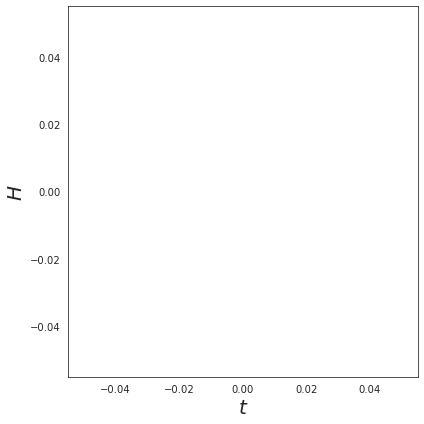

In [195]:
plt.plot(t, log['H'], linewidth=3)
format_plot('$t$', '$H$')
finalize_plot()

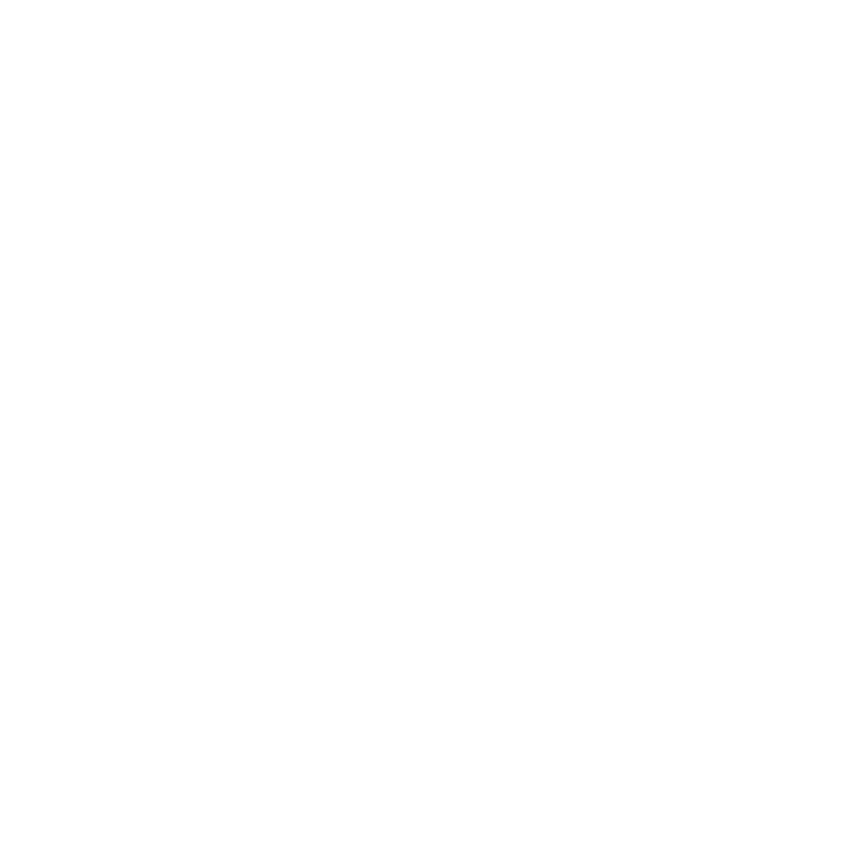

In [197]:
ms = 65
R_plt = onp.array(state.position)

plt.plot(R_plt, R_plt, 'o', markersize=ms * 1)
plt.plot(R_plt[particles_index[0]], R_plt[particles_index[1]], 'o', markersize=ms * 1)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

In [39]:
class Energy:

    def __init__(self, dim):
        super().__init__()
        self._dim = dim

    @property
    def dim(self):
        return self._dim

    def _energy(self, x):
        raise NotImplementedError()

    def energy(self, x, temperature=None):
        assert x.shape[-1] == self._dim, "`x` does not match `dim`"
        if temperature is None:
            temperature = 1.
        return self._energy(x) / temperature

    def force(self, x, temperature=None):
        e_func = lambda x: jnp.sum(self.energy(x, temperature=temperature))
        return -jax.grad(e_func)(x)

class DoubleWellEnergy(Energy):
    def __init__(self, dim, a=-0.5, b=-6.0, c=1.):
        super().__init__(dim)
        self._a = a
        self._b = b
        self._c = c

    def _energy(self, x):
        d = x[:, [0]]
        v = x[:, 1:]
        e1 = self._a * d + self._b * d**2 + self._c * d**4
        e2 = np.sum(0.5 * v**2, axis=-1, keepdims=True)
        return e1 + e2

    def log_prob(self, x):
        if len(x.shape) == 1:
            x = np.expand_dims(x, axis=0)
        return np.squeeze(-self.energy(x))

In [44]:
class ManyWellEnergy:
    def __init__(self, dim: int = 4, *args, **kwargs):
        assert dim % 2 == 0
        self.n_wells = dim // 2
        self.double_well_energy = DoubleWellEnergy(dim=2, *args, **kwargs)
        self.dim = dim

        self.centre = 1.7
        self.max_dim_for_all_modes = 40  # otherwise we get memory issues on huuuuge test set
        if self.dim < self.max_dim_for_all_modes:
            dim_1_vals_grid = np.meshgrid(*[np.array([-self.centre, self.centre])for _ in
                                              range(self.n_wells)])
            dim_1_vals = np.stack([dim.flatten() for dim in dim_1_vals_grid], axis=-1)
            n_modes = 2**self.n_wells
            assert n_modes == dim_1_vals.shape[0]
            test_set = np.zeros((n_modes, dim))
            test_set = test_set.at[:, np.arange(dim) % 2 == 0].set(dim_1_vals)
            self.test_set = test_set
        else:
            raise NotImplementedError("still need to implement this")

        self.shallow_well_bounds = [-1.75, -1.65]
        self.deep_well_bounds = [1.7, 1.8]

    def log_prob(self, x):
        return np.sum(np.stack([self.double_well_energy.log_prob(x[..., i*2:i*2+2]) for i in range(
                self.n_wells)], axis=-1), axis=-1)

    def log_prob_2D(self, x):
        """Marginal 2D pdf - useful for plotting."""
        return self.double_well_energy.log_prob(x)

In [53]:
import matplotlib as mpl
def plot_contours_2D(log_prob_func,
                     ax=None,
                     bound=3, levels=20):
    """Plot the contours of a 2D log prob function."""
    if ax is None:
        fig, ax = plt.subplots(1)
    n_points = 200
    x_points_dim1 = np.linspace(-bound, bound, n_points)
    x_points_dim2 = np.linspace(-bound, bound, n_points)
    x_points = np.array(list(itertools.product(x_points_dim1, x_points_dim2)))
    log_probs = log_prob_func(x_points)
    log_probs = jnp.clip(log_probs, a_min=-1000, a_max=None)
    x1 = x_points[:, 0].reshape(n_points, n_points)
    x2 = x_points[:, 1].reshape(n_points, n_points)
    z = log_probs.reshape(n_points, n_points)
    ax.contour(x1, x2, z, levels=levels)

In [54]:
dim = 2
energy = ManyWellEnergy(dim=2)
x = random.normal(random.PRNGKey(42), shape=(3, dim))
print(energy.log_prob(x))

import itertools
import matplotlib.pyplot as plt
bound = -3
n_points = 200
x_points_dim1 = np.linspace(-bound, bound, n_points)
x_points_dim2 = np.linspace(-bound, bound, n_points)
x_points = np.array(list(itertools.product(x_points_dim1, x_points_dim2)))
log_probs = energy.log_prob #(x_points)
fig = plt.figure(figsize=plt.figaspect(0.5))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
plot_contours_2D(np.exp(log_probs)) # n_points, ax, title="log p(x)")
plt.show()

[ 0.3011884  -0.63640294  6.43733472]


TypeError: Argument '<bound method ManyWellEnergy.log_prob of <__main__.ManyWellEnergy object at 0x7f9c5670eb80>>' of type <class 'method'> is not a valid JAX type.

<Figure size 576x288 with 0 Axes>